# &#x1F4D1; &nbsp; <span style="color:red"> Reflections. Artificial Intelligence for Robotics. Sections 19-22</span>

##   &#x1F916; &nbsp; <span style="color:red">Links</span>

##   &#x1F916; &nbsp; <span style="color:red">Libraries</span>

In [2]:
from math import *
import numpy as np
import pandas as pd
import random
import os
from time import time
from copy import deepcopy

In [3]:
from IPython.display import display, Image
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import offsetbox
%matplotlib inline

In [4]:
def prtRedBox(prt): print("\033[7;31m {} \033[7;00m" .format(prt))
prtRedBox('Text')    

 Text 


##   &#x1F916; &nbsp; <span style="color:red">Section 19. SLAM</span>

### Notes

### Examples

### Quizes

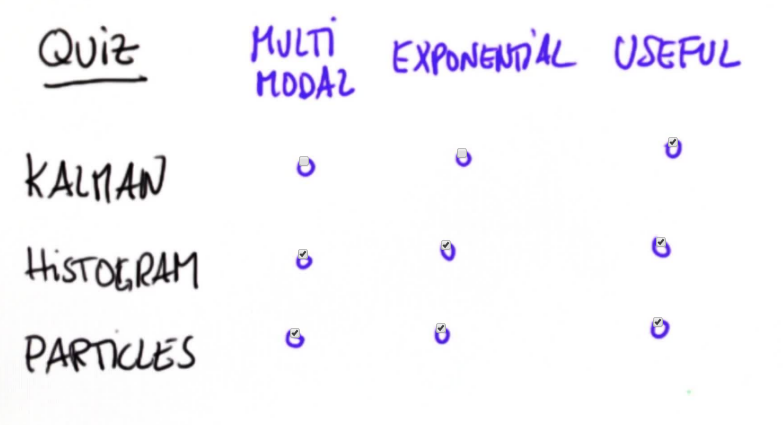

In [69]:
# Quiz: Localization
Image('373_02.png')

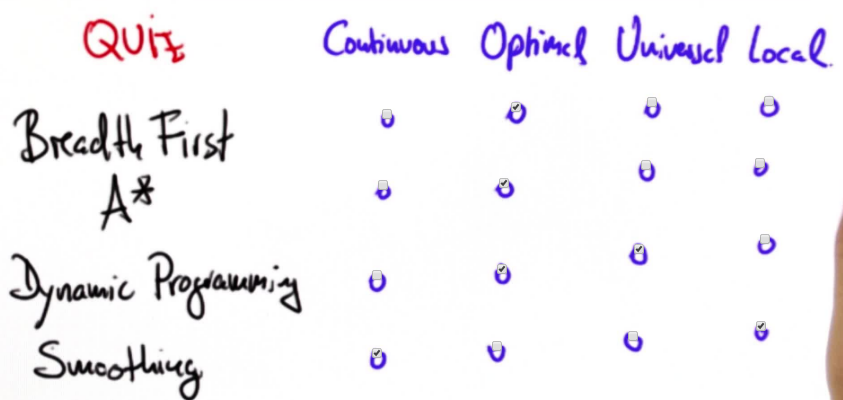

In [70]:
# Quiz: Planning
Image('373_03.png')

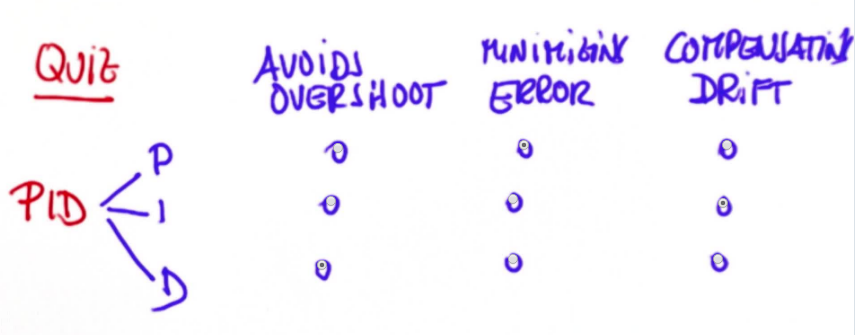

In [71]:
# Quiz: PID
Image('373_04.png')

In [72]:
# Quiz: Segmented CTE

In [12]:
# -----------
# User Instructions
#
# Familiarize yourself with the code below. Most of it
# reproduces results that you have obtained at some
# point in this class. Once you understand the code,
# write a function, cte, in the run class that
# computes the crosstrack
# error for the case of a segmented path. You will
# need to include the equations shown in the video.
#
 
# don't change the noise paameters

steering_noise    = 0.1
distance_noise    = 0.03
measurement_noise = 0.3

class plan:

    # --------
    # init: 
    #    creates an empty plan
    #

    def __init__(self, grid, init, goal, cost = 1):
        self.cost = cost
        self.grid = grid
        self.init = init
        self.goal = goal
        self.make_heuristic(grid, goal, self.cost)
        self.path = []
        self.spath = []

    # --------
    #
    # make heuristic function for a grid
        
    def make_heuristic(self, grid, goal, cost):
        self.heuristic = [[0 for row in range(len(grid[0]))] 
                          for col in range(len(grid))]
        for i in range(len(self.grid)):    
            for j in range(len(self.grid[0])):
                self.heuristic[i][j] = abs(i - self.goal[0]) + \
                    abs(j - self.goal[1])

    # ------------------------------------------------
    # 
    # A* for searching a path to the goal
    #
    #

    def astar(self):

        if self.heuristic == []:
            raise (ValueError, "Heuristic must be defined to run A*")

        # internal motion parameters
        delta = [[-1,  0], # go up
                 [ 0,  -1], # go left
                 [ 1,  0], # go down
                 [ 0,  1]] # do right

        # open list elements are of the type: [f, g, h, x, y]

        closed = [[0 for row in range(len(self.grid[0]))] 
                  for col in range(len(self.grid))]
        action = [[0 for row in range(len(self.grid[0]))] 
                  for col in range(len(self.grid))]

        closed[self.init[0]][self.init[1]] = 1

        x = self.init[0]
        y = self.init[1]
        h = self.heuristic[x][y]
        g = 0
        f = g + h

        open = [[f, g, h, x, y]]

        found  = False # flag that is set when search complete
        resign = False # flag set if we can't find expand
        count  = 0

        while not found and not resign:

            # check if we still have elements on the open list
            if len(open) == 0:
                resign = True
                print ('###### Search terminated without success')
                
            else:
                # remove node from list
                open.sort()
                open.reverse()
                next = open.pop()
                x = next[3]
                y = next[4]
                g = next[1]

            # check if we are done

            if x == goal[0] and y == goal[1]:
                found = True
                print ('###### A* search successful')

            else:
                # expand winning element and add to new open list
                for i in range(len(delta)):
                    x2 = x + delta[i][0]
                    y2 = y + delta[i][1]
                    if x2 >= 0 and x2 < len(self.grid) and y2 >= 0 \
                            and y2 < len(self.grid[0]):
                        if closed[x2][y2] == 0 and self.grid[x2][y2] == 0:
                            g2 = g + self.cost
                            h2 = self.heuristic[x2][y2]
                            f2 = g2 + h2
                            open.append([f2, g2, h2, x2, y2])
                            closed[x2][y2] = 1
                            action[x2][y2] = i

            count += 1

        # extract the path

        invpath = []
        x = self.goal[0]
        y = self.goal[1]
        invpath.append([x, y])
        while x != self.init[0] or y != self.init[1]:
            x2 = x - delta[action[x][y]][0]
            y2 = y - delta[action[x][y]][1]
            x = x2
            y = y2
            invpath.append([x, y])

        self.path = []
        for i in range(len(invpath)):
            self.path.append(invpath[len(invpath) - 1 - i])

    # ------------------------------------------------
    # 
    # this is the smoothing function
    #

    def smooth(self, weight_data = 0.1, weight_smooth = 0.1, 
               tolerance = 0.000001):

        if self.path == []:
            raise (ValueError, "Run A* first before smoothing path")

        self.spath = [[0 for row in range(len(self.path[0]))] for col in range(len(self.path))]
        
        for i in range(len(self.path)):
            for j in range(len(self.path[0])):
                self.spath[i][j] = self.path[i][j]

        change = tolerance
        while change >= tolerance:
            change = 0.0
            for i in range(1, len(self.path)-1):
                for j in range(len(self.path[0])):
                    aux = self.spath[i][j]
                    
                    self.spath[i][j] += weight_data * (self.path[i][j] - self.spath[i][j])
                    
                    self.spath[i][j] += weight_smooth * (self.spath[i-1][j] + self.spath[i+1][j] \
                        - (2.0 * self.spath[i][j]))
                    
                    if i >= 2:
                        self.spath[i][j] += 0.5 * weight_smooth * \
                            (2.0 * self.spath[i-1][j] - self.spath[i-2][j]  - self.spath[i][j])
                            
                    if i <= len(self.path) - 3:
                        self.spath[i][j] += 0.5 * weight_smooth * \
                            (2.0 * self.spath[i+1][j] - self.spath[i+2][j] - self.spath[i][j])
                
            change += abs(aux - self.spath[i][j])

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #	creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 0.5):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise    = 0.0
        self.distance_noise    = 0.0
        self.measurement_noise = 0.0
        self.num_collisions    = 0
        self.num_steps         = 0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)

    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise, new_m_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise     = float(new_s_noise)
        self.distance_noise    = float(new_d_noise)
        self.measurement_noise = float(new_m_noise)

    # --------
    # check: 
    #    checks of the robot pose collides with an obstacle, or
    # is too far outside the plane

    def check_collision(self, grid):
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if grid[i][j] == 1:
                    dist = sqrt((self.x - float(i)) ** 2 + 
                                (self.y - float(j)) ** 2)
                    if dist < 0.5:
                        self.num_collisions += 1
                        return False
        return True
        
    def check_goal(self, goal, threshold = 1.0):
        dist =  sqrt((float(goal[0]) - self.x) ** 2 + (float(goal[1]) - self.y) ** 2)
        return dist < threshold
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, grid, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # make a new copy
        res = robot()
        res.length            = self.length
        res.steering_noise    = self.steering_noise
        res.distance_noise    = self.distance_noise
        res.measurement_noise = self.measurement_noise
        res.num_collisions    = self.num_collisions
        res.num_steps         = self.num_steps + 1

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)


        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        # check for collision
        # res.check_collision(grid)

        return res

    # --------
    # sense: 
    #    

    def sense(self):

        return [random.gauss(self.x, self.measurement_noise),
                random.gauss(self.y, self.measurement_noise)]

    # --------
    # measurement_prob
    # computes the probability of a measurement
    # 

    def measurement_prob(self, measurement):

        # compute errors
        error_x = measurement[0] - self.x
        error_y = measurement[1] - self.y

        # calculate Gaussian
        error = exp(- (error_x ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))
        error *= exp(- (error_y ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))

        return error

    def __repr__(self):
        # return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
        return ('[%.5f, %.5f]'  % (self.x, self.y))

# ------------------------------------------------
# 
# this is the particle filter class
#

class particles:

    # --------
    # init: 
    #	creates particle set with given initial position
    #

    def __init__(self, x, y, theta, 
                 steering_noise, distance_noise, measurement_noise, N = 100):
        self.N = N
        self.steering_noise    = steering_noise
        self.distance_noise    = distance_noise
        self.measurement_noise = measurement_noise
        
        self.data = []
        for i in range(self.N):
            r = robot()
            r.set(x, y, theta)
            r.set_noise(steering_noise, distance_noise, measurement_noise)
            self.data.append(r)

    # --------
    #
    # extract position from a particle set
    # 
    
    def get_position(self):
        x = 0.0
        y = 0.0
        orientation = 0.0

        for i in range(self.N):
            x += self.data[i].x
            y += self.data[i].y
            # orientation is tricky because it is cyclic. By normalizing
            # around the first particle we are somewhat more robust to
            # the 0=2pi problem
            orientation += (((self.data[i].orientation
                              - self.data[0].orientation + pi) % (2.0 * pi)) 
                            + self.data[0].orientation - pi)
        return [x / self.N, y / self.N, orientation / self.N]

    # --------
    #
    # motion of the particles
    # 

    def move(self, grid, steer, speed):
        newdata = []

        for i in range(self.N):
            r = self.data[i].move(grid, steer, speed)
            newdata.append(r)
        self.data = newdata

    # --------
    #
    # sensing and resampling
    # 

    def sense(self, Z):
        w = []
        for i in range(self.N):
            w.append(self.data[i].measurement_prob(Z))

        # resampling (careful, this is using shallow copy)
        p3 = []
        index = int(random.random() * self.N)
        beta = 0.0
        mw = max(w)

        for i in range(self.N):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.N
            p3.append(self.data[index])
        self.data = p3

# --------
#
# run:  runs control program for the robot
#

def run(grid, goal, spath, params, printflag = False, speed = 0.1, timeout = 1000):

    myrobot = robot()
    myrobot.set(0., 0., 0.)
    myrobot.set_noise(steering_noise, distance_noise, measurement_noise)
    filter = particles(myrobot.x, myrobot.y, myrobot.orientation,
                       steering_noise, distance_noise, measurement_noise)

    cte  = 0.0
    err  = 0.0
    N    = 0

    index = 0 # index into the path
    
    while not myrobot.check_goal(goal) and N < timeout:

        diff_cte = - cte

        # ----------------------------------------
        # compute the CTE

        # start with the present robot estimate
        estimate = filter.get_position()

        ### ENTER CODE HERE
        dx = spath[index+1][0] - spath[index][0]
        dy = spath[index+1][1] - spath[index][1]
        drx = estimate[0] - spath[index][0]
        dry = estimate[1] - spath[index][1]
        
        # u is the robot estimate projectes onto the path segment
        u = (drx * dx + dry * dy) / (dx * dx + dy * dy)
        
        # the cte is the estimate projected onto the normal of the path segment
        cte = (dry * dx - drx * dy) / (dx * dx + dy * dy)
        
        # pick the next path segment
        if u > 1.0 and index < len(spath) - 1:
            index += 1        
       # ----------------------------------------

        diff_cte += cte

        steer = - params[0] * cte - params[1] * diff_cte 

        myrobot = myrobot.move(grid, steer, speed)
        filter.move(grid, steer, speed)

        Z = myrobot.sense()
        filter.sense(Z)

        if not myrobot.check_collision(grid):
            print ('##### Collision ####')

        err += (cte ** 2)
        N += 1

        if printflag:
            print (myrobot, cte, index, u)

    return [myrobot.check_goal(goal), myrobot.num_collisions, myrobot.num_steps]

# ------------------------------------------------
# 
# this is our main routine
#

def main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
     weight_data, weight_smooth, p_gain, d_gain):

    path = plan(grid, init, goal)
    path.astar()
    path.smooth(weight_data, weight_smooth)
    return run(grid, goal, path.spath, [p_gain, d_gain])

# ------------------------------------------------
# 
# input data and parameters
#

# grid format:
#   0 = navigable space
#   1 = occupied space

grid = [[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0]]


init = [0, 0]
goal = [len(grid)-1, len(grid[0])-1]

steering_noise    = 0.1
distance_noise    = 0.03
measurement_noise = 0.3

weight_data       = 0.1
weight_smooth     = 0.2
p_gain            = 2.0
d_gain            = 6.0
   
print (main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
           weight_data, weight_smooth, p_gain, d_gain))

def twiddle(init_params):
    n_params   = len(init_params)
    dparams    = [1.0 for row in range(n_params)]
    params     = [0.0 for row in range(n_params)]
    K = 10

    for i in range(n_params):
        params[i] = init_params[i]

    best_error = 0.0;
    for k in range(K):
        ret = main(grid, init, goal, 
                   steering_noise, distance_noise, measurement_noise, 
                   params[0], params[1], params[2], params[3])
        if ret[0]:
            best_error += ret[1] * 100 + ret[2]
        else:
            best_error += 99999
    best_error = float(best_error) / float(k+1)
    print (best_error)

    n = 0
    while sum(dparams) > 0.0000001:
        for i in range(len(params)):
            params[i] += dparams[i]
            err = 0
            for k in range(K):
                ret = main(grid, init, goal, 
                           steering_noise, distance_noise, measurement_noise, 
                           params[0], params[1], params[2], params[3])
                if ret[0]:
                    err += ret[1] * 100 + ret[2]
                else:
                    err += 99999
            print (float(err) / float(k+1))
            if err < best_error:
                best_error = float(err) / float(k+1)
                dparams[i] *= 1.1
            else:
                params[i] -= 2.0 * dparams[i]            
                err = 0
                for k in range(K):
                    ret = main(grid, init, goal, 
                               steering_noise, distance_noise, measurement_noise, 
                               params[0], params[1], params[2], params[3])
                    if ret[0]:
                        err += ret[1] * 100 + ret[2]
                    else:
                        err += 99999
                print (float(err) / float(k+1))
                if err < best_error:
                    best_error = float(err) / float(k+1)
                    dparams[i] *= 1.1
                else:
                    params[i] += dparams[i]
                    dparams[i] *= 0.5
        n += 1
        print ('Twiddle #', n, params, ' -> ', best_error)
    print (' ')
    return params

###### A* search successful
[True, 0, 146]


In [13]:
twiddle([weight_data, weight_smooth, p_gain, d_gain])

###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
182.6
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
173.5
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
99999.0
###### A* search successful
###### 

###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
99999.0
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* se

###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
171.7
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
164.0
Twiddle # 4 [0.10000000000000009, 0.19999999999999996, 2.0, 6.0]  ->  182.6
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
226.0
###### A* search success

###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
213.5
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
363.8
###### A* search successful
###### A* search succe

###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
360.1
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### C

###### A* search successful
161.9
###### A* search successful
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
159.8
Twiddle # 10 [0.10000000000000009, 0.19999999999999996, 2.0, 6.0]  ->  182.6
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
##### Collision ####
##### Co

##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
182.6
Twiddle # 12 [0.10000000000000009, 0.19999999999999996, 2.0, 6.0]  ->  182.6
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
###### A* search successful
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
180.9
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A

###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
##### Collision ####
###### A* search successful
281.4
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
##### Collision ####
##### Collision ####
##### Collisio

###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
211.0
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
241.9
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
#

###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
381.5
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####


139.1
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
143.4
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
283.9
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search

###### A* search successful
##### Collision ####
##### Collision ####
###### A* search successful
191.4
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
232.1
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
181.8
Twiddle # 23 [0.10000000000000009, 0.19999999999999

###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
140.4
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
###### A* search successful
###### A* search successful
252.1
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
###### A* search successful
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
###### A* search successful
##### Collision ####
##### Collision ####
###### A

[0.10000000000000009, 0.19999999999999996, 2.0, 6.0]

In [14]:
# Quiz: Fun With Parameters
# ------------------------------------------------
# 
# this is our main routine
#

def main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
     weight_data, weight_smooth, p_gain, d_gain):

    path = plan(grid, init, goal)
    path.astar()
    path.smooth(weight_data, weight_smooth)
    return run(grid, goal, path.spath, [p_gain, d_gain])

# ------------------------------------------------
# 
# input data and parameters
#

# grid format:
#   0 = navigable space
#   1 = occupied space

grid = [[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0]]

init = [0, 0]
goal = [len(grid)-1, len(grid[0])-1]

steering_noise    = 0.1
distance_noise    = 0.03
measurement_noise = 0.3

#### ADJUST THESE PARAMETERS ######

weight_data       = 0.1
weight_smooth     = 0.2
p_gain            = 2.0
d_gain            = 6.0

###################################

In [15]:
print (main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
           weight_data, weight_smooth, p_gain, d_gain))

###### A* search successful
[True, 0, 138]


In [17]:
# Quiz: Is Localization Necessary
# Yes

In [18]:
# Quiz: Graph SLAM
# 14

In [34]:
# Quiz: Implementing Constraints

# x1 = x0 + 5

#                                         x0      x1     x2          vector 
# 1 * x0 + (-1) * x1 = -5          x0 ##  1      -1                x0 ##   -5
# (-1) * x0 + 1 * x1 = 5           x1 ##  -1      1                x1 ##   5
#                                  x2 ##

# x2 = x1 - 4

#                                         x0      x1     x2           vector 
#                                  x0 ##  1      -1                 x0 ##  -5
# 1 * x1 + (-1) * x2 = 4           x1 ##  -1    1+1=2   -1          x1 ## 5+4=9
# (-1) * x1 + 1 * x2 = -4          x2 ##         -1      1          x2 ##  -4

In [6]:
# Quiz: Adding Landmarks
# L0 = x1 + 9

#                                         x0      x1     x2     L0     L1      vector 
#                                  x0 ##  1      -1                            x0 ##  -5
# 1 * x1 + (-1) * L0 = -9          x1 ##  -1    2+1=3   -1      -1             x1 ##  9-9=0
#                                  x2 ##         -1      1                     x2 ##  -4
# (-1) * x1 + 1 * L0 = 9           L0 ##         1              1              L0 ##  9
#                                  L1 ##                                       L1 ##   

In [5]:
# Quiz: SLAM Quiz
# All about local constraints
# They require addition

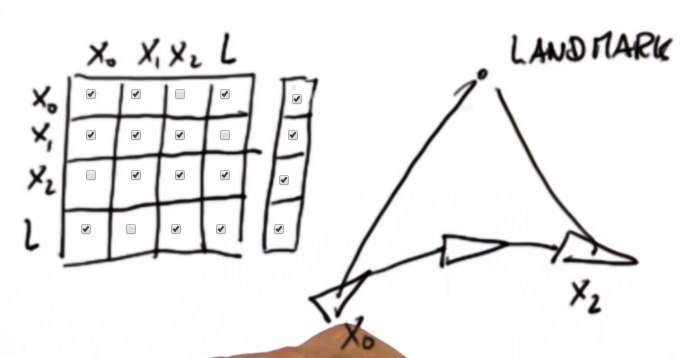

In [7]:
# Quiz: Matrix Modification
Image('373_05.png')

In [8]:
# Quiz: Untouched Fields
# 8 (4 for any missing edge)

In [14]:
# Quiz: Omega And Xi
# -----------
# User Instructions
#
# Write a function, doit, that takes as its input an
# initial robot position, move1, and move2. This
# function should compute the Omega and Xi matrices
# discussed in lecture and should RETURN the mu vector
# (which is the product of Omega.inverse() and Xi).
#
# Please enter your code at the bottom.

#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#      
# 
#===============================================================

# ------------------------------------------------
# 
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
# 

class matrix:
    
    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy = 0):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise (ValueError, "Invalid size of matrix")
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #


    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise (ValueError, "Invalid size of matrix")
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
    # ------------
    #
    # prints out values of matrix
    #

    def show(self, txt = ''):
        for i in range(len(self.value)):
            print (txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']')
        print (' ')

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #


    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimx != other.dimx:
            raise (ValueError, "Matrices must be of equal dimension to add")
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimx != other.dimx:
            raise (ValueError, "Matrices must be of equal dimension to subtract")
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #

    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise (ValueError, "Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res

    # ------------
    #
    # returns a matrix transpose
    #

    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5], 
    #                   [ 6,  7,  8,  9, 10], 
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #       
    #       [[1, 3, 4], 
    #        [11, 13, 14]]
    #       
    # 
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # is no list2 is provided, then list2 is set to list1 (good for symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise (ValueError, "list invalid in take()")

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0], 
    #        [0, 0, 0, 0, 0], 
    #        [4, 0, 5, 6, 0]]
    # 
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns 
    # that are not listed in list1/list2 
    # will be initialized by 0.0.
    #

    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise (ValueError, "list invalid in expand()")

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of  
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def Cholesky(self, ztol= 1.0e-5):
        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else: 
                if d < 0.0:
                    raise (ValueError, "Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
        return res 
 
    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def CholeskyInverse(self):
        res = matrix()
        res.zero(self.dimx, self.dimx)

    # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res
    
    # ------------
    #
    # comutes and returns the inverse of a square matrix
    #

    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #

    def __repr__(self):
        return repr(self.value)

# ######################################################################
# ######################################################################
# ######################################################################

"""
For the following example, you would call doit(-3, 5, 3):
3 robot positions
  initially: -3
  moves by 5
  moves by 3 

which should return a mu of:
[[-3.0],
 [2.0],
 [5.0]]
"""
def do_it(initial_pos, move1, move2):
    #
    #
    # Add your code here.
    #
    #
    omega_matrix = matrix([[1., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
    x = matrix([[initial_pos], [0.], [0.]])
    
    omega_matrix += matrix([[1., -1., 0.], [-1., 1., 0.], [0., 0., 0.]])
    x += matrix([[-move1], [move1], [0.]])
    
    omega_matrix += matrix([[0., 0., 0.], [0., 1., -1.], [0., -1., 1.]])
    x += matrix([[0.], [-move2], [move2]])
    
    omega_inverse_x = omega_matrix.inverse() * x
    
    omega_matrix.show()
    x.show()
    omega_inverse_x.show()
    
    return omega_inverse_x

In [16]:
result = do_it(-3, 5, 3)

[2.000, -1.000, 0.000]
[-1.000, 2.000, -1.000]
[0.000, -1.000, 1.000]
 
[-8.000]
[2.000]
[3.000]
 
[-3.000]
[2.000]
[5.000]
 


In [51]:
# Quiz: Landmark Position
np.array([7, 7, 7]) - np.array([-3., 2., 5.]) 

array([ 10.,   5.,   2.])

In [39]:
# Quiz: Expand
# -----------
# User Instructions
#
# Modify your doit function to incorporate 3
# distance measurements to a landmark(Z0, Z1, Z2).
# You should use the provided expand function to
# allow your Omega and Xi matrices to accomodate
# the new information.
#
# Each landmark measurement should modify 4
# values in your Omega matrix and 2 in your
# Xi vector.
#
#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#      
# 
#===============================================================
"""
For the following example, you would call doit(-3, 5, 3, 10, 5, 2):
3 robot positions
  initially: -3 (measure landmark to be 10 away)
  moves by 5 (measure landmark to be 5 away)
  moves by 3 (measure landmark to be 2 away)

which should return a mu of:
[[-3.0],
 [2.0],
 [5.0],
 [7.0]]
"""
def do_it2(initial_pos, move1, move2, Z0, Z1, Z2):
    Omega = matrix([[1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0]])
    Xi = matrix([[initial_pos],
                 [0.0],
                 [0.0]])

    Omega += matrix([[1.0, -1.0, 0.0],
                     [-1.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])
    Xi += matrix([[-move1],
                  [move1],
                  [0.0]])
    
    Omega += matrix([[0.0, 0.0, 0.0],
                     [0.0, 1.0, -1.0],
                     [0.0, -1.0, 1.0]])
    Xi += matrix([[0.0],
                  [-move2],
                  [move2]])

    #
    #
    # Add your code here.
    #
    #

    Omega.show('Omega: ')
    Xi.show('Xi:    ')
    mu = Omega.inverse() * Xi
    mu.show('Mu:    ')
    
    return mu

In [52]:
# Quiz: Introducing Noise
np.array([7, 7, 7]) - np.array([-3., 2., 6.])

array([ 10.,   5.,   1.])

In [ ]:
# Quiz: Confident Measurements
# -----------
# User Instructions
#
# Modify the previous code to adjust for a highly
# confident last measurement. Do this by adding a
# factor of 5 into your Omega and Xi matrices
# as described in the video.


 
from math import *
import random


#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#      
# 
#===============================================================


# ------------------------------------------------
# 
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
# 

class matrix:
    
    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy = 0):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError, "Invalid size of matrix"
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #


    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError, "Invalid size of matrix"
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
    # ------------
    #
    # prints out values of matrix
    #


    def show(self, txt = ''):
        for i in range(len(self.value)):
            print txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']' 
        print ' '

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #

    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimx != other.dimx:
            raise ValueError, "Matrices must be of equal dimension to add"
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimx != other.dimx:
            raise ValueError, "Matrices must be of equal dimension to subtract"
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #


    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError, "Matrices must be m*n and n*p to multiply"
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res


    # ------------
    #
    # returns a matrix transpose
    #


    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5], 
    #                   [ 6,  7,  8,  9, 10], 
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #       
    #       [[1, 3, 4], 
    #        [11, 13, 14]]
    #       
    # 
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # is no list2 is provided, then list2 is set to list1 (good for symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError, "list invalid in take()"

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0], 
    #        [0, 0, 0, 0, 0], 
    #        [4, 0, 5, 6, 0]]
    # 
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns 
    # that are not listed in list1/list2 
    # will be initialized by 0.0.
    #

    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError, "list invalid in expand()"

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of  
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def Cholesky(self, ztol= 1.0e-5):


        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else: 
                if d < 0.0:
                    raise ValueError, "Matrix not positive-definite"
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
        return res 
 
    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def CholeskyInverse(self):
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
        # This code is based on http://adorio-research.org/wordpress/?p=4560

        res = matrix()
        res.zero(self.dimx, self.dimx)

    # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res
    
    # ------------
    #
    # comutes and returns the inverse of a square matrix
    #


    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #


    def __repr__(self):
        return repr(self.value)

# ######################################################################
# ######################################################################
# ######################################################################

# Including the 5 times multiplier, your returned mu should now be:
#
# [[-3.0],
#  [2.179],
#  [5.714],
#  [6.821]]

############## MODIFY CODE BELOW ##################

def doit(initial_pos, move1, move2, Z0, Z1, Z2):
    Omega = matrix([[1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0]])
    Xi    = matrix([[initial_pos],
                    [0.0],
                    [0.0]])

    Omega += matrix([[1.0, -1.0, 0.0],
                     [-1.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0]])
    Xi    += matrix([[-move1],
                     [move1],
                     [0.0]])
    
    Omega += matrix([[0.0, 0.0, 0.0],
                     [0.0, 1.0, -1.0],
                     [0.0, -1.0, 1.0]])
    Xi    += matrix([[0.0],
                     [-move2],
                     [move2]])
    
    Omega = Omega.expand(4, 4, [0, 1, 2], [0, 1, 2])
    Xi =    Xi.expand(4, 1, [0, 1, 2], [0])

    Omega += matrix([[1.0, 0.0, 0.0, -1.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [-1.0, 0.0, 0.0, 1.0]])
    Xi    += matrix([[-Z0],
                     [0.0],
                     [0.0],
                     [Z0]])

    Omega += matrix([[0.0, 0.0, 0.0, 0.0],
                     [0.0, 1.0, 0.0, -1.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [0.0, -1.0, 0.0, 1.0]])
    Xi    += matrix([[0.0],
                     [-Z1],
                     [0.0],
                     [Z1]])

    Omega += matrix([[0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 1.0, -1.0],
                     [0.0, 0.0, -1.0, 1.0]])
    Xi    += matrix([[0.0],
                     [0.0],
                     [-Z2],
                     [Z2]])

    Omega.show('Omega: ')
    Xi.show('Xi:    ')
    mu = Omega.inverse() * Xi
    mu.show('Mu:    ')
    
    return mu

In [ ]:
doit(-3, 5, 3, 10, 5, 1)

In [ ]:
# Quiz: Implementing SLAM
# ------------
# User Instructions
# 
# In this problem you will implement SLAM in a 2 dimensional
# world. Please define a function, slam, which takes five
# parameters as input and returns the vector mu. This vector
# should have x, y coordinates interlaced, so for example, 
# if there were 2 poses and 2 landmarks, mu would look like:
#
#  mu =  matrix([[Px0],
#                [Py0],
#                [Px1],
#                [Py1],
#                [Lx0],
#                [Ly0],
#                [Lx1],
#                [Ly1]])
#
# data - This is the data that is generated with the included
#        make_data function. You can also use test_data to
#        make sure your function gives the correct result.
#
# N -    The number of time steps.
#
# num_landmarks - The number of landmarks.
#
# motion_noise - The noise associated with motion. The update
#                strength for motion should be 1.0 / motion_noise.
#
# measurement_noise - The noise associated with measurement.
#                     The update strength for measurement should be
#                     1.0 / measurement_noise.
#
#
# Enter your code at line 509

# --------------
# Testing
#
# Uncomment the test cases at the bottom of this document.
# Your output should be identical to the given results.

 
from math import *
import random


#===============================================================
#
# SLAM in a rectolinear world (we avoid non-linearities)
#      
# 
#===============================================================


# ------------------------------------------------
# 
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
# 

class matrix:
    
    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError, "Invalid size of matrix"
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #

    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError, "Invalid size of matrix"
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
    # ------------
    #
    # prints out values of matrix
    #

    def show(self, txt = ''):
        for i in range(len(self.value)):
            print txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']' 
        print ' '

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #

    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimx != other.dimx:
            raise ValueError, "Matrices must be of equal dimension to add"
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimx != other.dimx:
            raise ValueError, "Matrices must be of equal dimension to subtract"
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #

    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError, "Matrices must be m*n and n*p to multiply"
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res


    # ------------
    #
    # returns a matrix transpose
    #

    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5], 
    #                   [ 6,  7,  8,  9, 10], 
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #       
    #       [[1, 3, 4], 
    #        [11, 13, 14]]
    #       
    # 
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # if no list2 is provided, then list2 is set to list1 (good for 
    # symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError, "list invalid in take()"

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0], 
    #        [0, 0, 0, 0, 0], 
    #        [4, 0, 5, 6, 0]]
    # 
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns 
    # that are not listed in list1/list2 
    # will be initialized by 0.0.
    #
    
    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError, "list invalid in expand()"

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of  
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560
    #
    
    def Cholesky(self, ztol= 1.0e-5):

        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else: 
                if d < 0.0:
                    raise ValueError, "Matrix not positive-definite"
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
        return res 
 
    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560
    #
    
    def CholeskyInverse(self):

        res = matrix()
        res.zero(self.dimx, self.dimx)

        # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res
    
    # ------------
    #
    # computes and returns the inverse of a square matrix
    #
    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #
    def __repr__(self):
        return repr(self.value)

# ------------------------------------------------
# 
# this is the robot class
# 
# our robot lives in x-y space, and its motion is
# pointed in a random direction. It moves on a straight line
# until is comes close to a wall at which point it turns
# away from the wall and continues to move.
#
# For measurements, it simply senses the x- and y-distance
# to landmarks. This is different from range and bearing as 
# commonly studied in the literature, but this makes it much
# easier to implement the essentials of SLAM without
# cluttered math
#

class robot:

    # --------
    # init: 
    #   creates robot and initializes location to 0, 0
    #

    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0


    def rand(self):
        return random.random() * 2.0 - 1.0

    # --------
    #
    # make random landmarks located in the world
    #

    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks


    # --------
    #
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #

    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True
    

    # --------
    #
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #

    def sense(self):
        Z = []
        for i in range(self.num_landmarks):
            dx = self.landmarks[i][0] - self.x + self.rand() * self.measurement_noise
            dy = self.landmarks[i][1] - self.y + self.rand() * self.measurement_noise    
            if self.measurement_range < 0.0 or abs(dx) + abs(dy) <= self.measurement_range:
                Z.append([i, dx, dy])
        return Z

    # --------
    #
    # print robot location
    #

    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)

######################################################

# --------
# this routine makes the robot data
#

def make_data(N, num_landmarks, world_size, measurement_range, motion_noise, 
              measurement_noise, distance):


    complete = False

    while not complete:

        data = []

        # make robot and landmarks
        r = robot(world_size, measurement_range, motion_noise, measurement_noise)
        r.make_landmarks(num_landmarks)
        seen = [False for row in range(num_landmarks)]
    
        # guess an initial motion
        orientation = random.random() * 2.0 * pi
        dx = cos(orientation) * distance
        dy = sin(orientation) * distance
    
        for k in range(N-1):
    
            # sense
            Z = r.sense()

            # check off all landmarks that were observed 
            for i in range(len(Z)):
                seen[Z[i][0]] = True
    
            # move
            while not r.move(dx, dy):
                # if we'd be leaving the robot world, pick instead a new direction
                orientation = random.random() * 2.0 * pi
                dx = cos(orientation) * distance
                dy = sin(orientation) * distance

            # memorize data
            data.append([Z, [dx, dy]])

        # we are done when all landmarks were observed; otherwise re-run
        complete = (sum(seen) == num_landmarks)

    print ' '
    print 'Landmarks: ', r.landmarks
    print r


    return data
    
####################################################

# --------------------------------
#
# print the result of SLAM, the robot pose(s) and the landmarks
#

def print_result(N, num_landmarks, result):
    print
    print 'Estimated Pose(s):'
    for i in range(N):
        print '    ['+ ', '.join('%.3f'%x for x in result.value[2*i]) + ', ' \
            + ', '.join('%.3f'%x for x in result.value[2*i+1]) +']'
    print
    print 'Estimated Landmarks:'
    for i in range(num_landmarks):
        print '    ['+ ', '.join('%.3f'%x for x in result.value[2*(N+i)]) + ', ' \
            + ', '.join('%.3f'%x for x in result.value[2*(N+i)+1]) +']'

# --------------------------------
#
# slam - retains entire path and all landmarks
#

############## ENTER YOUR CODE BELOW HERE ###################

def slam(data, N, num_landmarks, motion_noise, measurement_noise):
    #
    #
    # Add your code here!
    #
    #
    return mu # Make sure you return mu for grading!
        
############### ENTER YOUR CODE ABOVE HERE ###################

# ------------------------------------------------------------------------
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------
#
# Main routines
#


num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 

data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)
result = slam(data, N, num_landmarks, motion_noise, measurement_noise)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
print_result(N, num_landmarks, result)

# -------------
# Testing
#
# Uncomment one of the test cases below to compare your results to
# the results shown for Test Case 1 and Test Case 2.

test_data1 = [[[[1, 19.457599255548065, 23.8387362100849], [2, -13.195807561967236, 11.708840328458608], [3, -30.0954905279171, 15.387879242505843]], [-12.2607279422326, -15.801093326936487]], [[[2, -0.4659930049620491, 28.088559771215664], [4, -17.866382374890936, -16.384904503932]], [-12.2607279422326, -15.801093326936487]], [[[4, -6.202512900833806, -1.823403210274639]], [-12.2607279422326, -15.801093326936487]], [[[4, 7.412136480918645, 15.388585962142429]], [14.008259661173426, 14.274756084260822]], [[[4, -7.526138813444998, -0.4563942429717849]], [14.008259661173426, 14.274756084260822]], [[[2, -6.299793150150058, 29.047830407717623], [4, -21.93551130411791, -13.21956810989039]], [14.008259661173426, 14.274756084260822]], [[[1, 15.796300959032276, 30.65769689694247], [2, -18.64370821983482, 17.380022987031367]], [14.008259661173426, 14.274756084260822]], [[[1, 0.40311325410337906, 14.169429532679855], [2, -35.069349468466235, 2.4945558982439957]], [14.008259661173426, 14.274756084260822]], [[[1, -16.71340983241936, -2.777000269543834]], [-11.006096015782283, 16.699276945166858]], [[[1, -3.611096830835776, -17.954019226763958]], [-19.693482634035977, 3.488085684573048]], [[[1, 18.398273354362416, -22.705102332550947]], [-19.693482634035977, 3.488085684573048]], [[[2, 2.789312482883833, -39.73720193121324]], [12.849049222879723, -15.326510824972983]], [[[1, 21.26897046581808, -10.121029799040915], [2, -11.917698965880655, -23.17711662602097], [3, -31.81167947898398, -16.7985673023331]], [12.849049222879723, -15.326510824972983]], [[[1, 10.48157743234859, 5.692957082575485], [2, -22.31488473554935, -5.389184118551409], [3, -40.81803984305378, -2.4703329790238118]], [12.849049222879723, -15.326510824972983]], [[[0, 10.591050242096598, -39.2051798967113], [1, -3.5675572049297553, 22.849456408289125], [2, -38.39251065320351, 7.288990306029511]], [12.849049222879723, -15.326510824972983]], [[[0, -3.6225556479370766, -25.58006865235512]], [-7.8874682868419965, -18.379005523261092]], [[[0, 1.9784503557879374, -6.5025974151499]], [-7.8874682868419965, -18.379005523261092]], [[[0, 10.050665232782423, 11.026385307998742]], [-17.82919359778298, 9.062000642947142]], [[[0, 26.526838150174818, -0.22563393232425621], [4, -33.70303936886652, 2.880339841013677]], [-17.82919359778298, 9.062000642947142]]]
test_data2 = [[[[0, 26.543274387283322, -6.262538160312672], [3, 9.937396825799755, -9.128540360867689]], [18.92765331253674, -6.460955043986683]], [[[0, 7.706544739722961, -3.758467215445748], [1, 17.03954411948937, 31.705489938553438], [3, -11.61731288777497, -6.64964096716416]], [18.92765331253674, -6.460955043986683]], [[[0, -12.35130507136378, 2.585119104239249], [1, -2.563534536165313, 38.22159657838369], [3, -26.961236804740935, -0.4802312626141525]], [-11.167066095509824, 16.592065417497455]], [[[0, 1.4138633151721272, -13.912454837810632], [1, 8.087721200818589, 20.51845934354381], [3, -17.091723454402302, -16.521500551709707], [4, -7.414211721400232, 38.09191602674439]], [-11.167066095509824, 16.592065417497455]], [[[0, 12.886743222179561, -28.703968411636318], [1, 21.660953298391387, 3.4912891084614914], [3, -6.401401414569506, -32.321583037341625], [4, 5.034079343639034, 23.102207946092893]], [-11.167066095509824, 16.592065417497455]], [[[1, 31.126317672358578, -10.036784369535214], [2, -38.70878528420893, 7.4987265861424595], [4, 17.977218575473767, 6.150889254289742]], [-6.595520680493778, -18.88118393939265]], [[[1, 41.82460922922086, 7.847527392202475], [3, 15.711709540417502, -30.34633659912818]], [-6.595520680493778, -18.88118393939265]], [[[0, 40.18454208294434, -6.710999804403755], [3, 23.019508919299156, -10.12110867290604]], [-6.595520680493778, -18.88118393939265]], [[[3, 27.18579315312821, 8.067219022708391]], [-6.595520680493778, -18.88118393939265]], [[], [11.492663265706092, 16.36822198838621]], [[[3, 24.57154567653098, 13.461499960708197]], [11.492663265706092, 16.36822198838621]], [[[0, 31.61945290413707, 0.4272295085799329], [3, 16.97392299158991, -5.274596836133088]], [11.492663265706092, 16.36822198838621]], [[[0, 22.407381798735177, -18.03500068379259], [1, 29.642444125196995, 17.3794951934614], [3, 4.7969752441371645, -21.07505361639969], [4, 14.726069092569372, 32.75999422300078]], [11.492663265706092, 16.36822198838621]], [[[0, 10.705527984670137, -34.589764174299596], [1, 18.58772336795603, -0.20109708164787765], [3, -4.839806195049413, -39.92208742305105], [4, 4.18824810165454, 14.146847823548889]], [11.492663265706092, 16.36822198838621]], [[[1, 5.878492140223764, -19.955352450942357], [4, -7.059505455306587, -0.9740849280550585]], [19.628527845173146, 3.83678180657467]], [[[1, -11.150789592446378, -22.736641053247872], [4, -28.832815721158255, -3.9462962046291388]], [-19.841703647091965, 2.5113335861604362]], [[[1, 8.64427397916182, -20.286336970889053], [4, -5.036917727942285, -6.311739993868336]], [-5.946642674882207, -19.09548221169787]], [[[0, 7.151866679283043, -39.56103232616369], [1, 16.01535401373368, -3.780995345194027], [4, -3.04801331832137, 13.697362774960865]], [-5.946642674882207, -19.09548221169787]], [[[0, 12.872879480504395, -19.707592098123207], [1, 22.236710716903136, 16.331770792606406], [3, -4.841206109583004, -21.24604435851242], [4, 4.27111163223552, 32.25309748614184]], [-5.946642674882207, -19.09548221169787]]] 

##  Test Case 1
##
##  Estimated Pose(s):
##      [49.999, 49.999]
##      [37.971, 33.650]
##      [26.183, 18.153]
##      [13.743, 2.114]
##      [28.095, 16.781]
##      [42.383, 30.900]
##      [55.829, 44.494]
##      [70.855, 59.697]
##      [85.695, 75.540]
##      [74.010, 92.431]
##      [53.543, 96.451]
##      [34.523, 100.078]
##      [48.621, 83.951]
##      [60.195, 68.105]
##      [73.776, 52.932]
##      [87.130, 38.536]
##      [80.301, 20.506]
##      [72.797, 2.943]
##      [55.244, 13.253]
##      [37.414, 22.315]
##  
##  Estimated Landmarks:
##      [82.954, 13.537]
##      [70.493, 74.139]
##      [36.738, 61.279]
##      [18.696, 66.057]
##      [20.633, 16.873]


##  Test Case 2
##
##  Estimated Pose(s):
##      [49.999, 49.999]
##      [69.180, 45.664]
##      [87.742, 39.702]
##      [76.269, 56.309]
##      [64.316, 72.174]
##      [52.256, 88.151]
##      [44.058, 69.399]
##      [37.001, 49.916]
##      [30.923, 30.953]
##      [23.507, 11.417]
##      [34.179, 27.131]
##      [44.154, 43.844]
##      [54.805, 60.919]
##      [65.697, 78.544]
##      [77.467, 95.624]
##      [96.801, 98.819]
##      [75.956, 99.969]
##      [70.199, 81.179]
##      [64.053, 61.721]
##      [58.106, 42.626]
##  
##  Estimated Landmarks:
##      [76.778, 42.885]
##      [85.064, 77.436]
##      [13.546, 95.649]
##      [59.448, 39.593]
##      [69.262, 94.238]



### Uncomment the following three lines for test case 1 ###

#result = slam(test_data1, 20, 5, 2.0, 2.0)
#print_result(20, 5, result)
#print result


### Uncomment the following three lines for test case 2 ###

#result = slam(test_data2, 20, 5, 2.0, 2.0)
#print_result(20, 5, result)
#print result    
    

In [ ]:
# Quiz: Congratulations
# Congratulations! You have completed all of the content in
# the course. Amazing work. 
#
# If you have any message for us, feel free to write a print
# statement below and submit it. 
#
# Good luck with the homework and the final exam!

##   &#x1F916; &nbsp; <span style="color:red">Section 20. Problem Set 6</span>

In [ ]:
# Quiz: Matrix Fill In

In [ ]:
# Quiz: Online SLAM

In [ ]:
# ------------
# User Instructions
#
# In this problem you will implement a more manageable
# version of graph SLAM in 2 dimensions. 
#
# Define a function, online_slam, that takes 5 inputs:
# data, N, num_landmarks, motion_noise, and
# measurement_noise--just as was done in the last 
# programming assignment of unit 6. This function
# must return TWO matrices, mu and the final Omega.
#
# Just as with the quiz, your matrices should have x
# and y interlaced, so if there were two poses and 2
# landmarks, mu would look like:
#
# mu = matrix([[Px0],
#              [Py0],
#              [Px1],
#              [Py1],
#              [Lx0],
#              [Ly0],
#              [Lx1],
#              [Ly1]])
#
# Enter your code at line 566.

# -----------
# Testing
#
# You have two methods for testing your code.
#
# 1) You can make your own data with the make_data
#    function. Then you can run it through the
#    provided slam routine and check to see that your
#    online_slam function gives the same estimated
#    final robot pose and landmark positions.
# 2) You can use the solution_check function at the
#    bottom of this document to check your code
#    for the two provided test cases. The grading
#    will be almost identical to this function, so
#    if you pass both test cases, you should be
#    marked correct on the homework.

from math import *
import random


# ------------------------------------------------
# 
# this is the matrix class
# we use it because it makes it easier to collect constraints in GraphSLAM
# and to calculate solutions (albeit inefficiently)
# 

class matrix:
    
    # implements basic operations of a matrix class

    # ------------
    #
    # initialization - can be called with an initial matrix
    #

    def __init__(self, value = [[]]):
        self.value = value
        self.dimx  = len(value)
        self.dimy  = len(value[0])
        if value == [[]]:
            self.dimx = 0
            
    # -----------
    #
    # defines matrix equality - returns true if corresponding elements
    #   in two matrices are within epsilon of each other.
    #
    
    def __eq__(self, other):
        epsilon = 0.01
        if self.dimx != other.dimx or self.dimy != other.dimy:
            return False
        for i in range(self.dimx):
            for j in range(self.dimy):
                if abs(self.value[i][j] - other.value[i][j]) > epsilon:
                    return False
        return True
    
    def __ne__(self, other):
        return not (self == other)

    # ------------
    #
    # makes matrix of a certain size and sets each element to zero
    #

    def zero(self, dimx, dimy):
        if dimy == 0:
            dimy = dimx
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError, "Invalid size of matrix"
        else:
            self.dimx  = dimx
            self.dimy  = dimy
            self.value = [[0.0 for row in range(dimy)] for col in range(dimx)]

    # ------------
    #
    # makes matrix of a certain (square) size and turns matrix into identity matrix
    #

    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError, "Invalid size of matrix"
        else:
            self.dimx  = dim
            self.dimy  = dim
            self.value = [[0.0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1.0
                
    # ------------
    #
    # prints out values of matrix
    #

    def show(self, txt = ''):
        for i in range(len(self.value)):
            print txt + '['+ ', '.join('%.3f'%x for x in self.value[i]) + ']' 
        print ' '

    # ------------
    #
    # defines elmement-wise matrix addition. Both matrices must be of equal dimensions
    #

    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimx != other.dimx:
            raise ValueError, "Matrices must be of equal dimension to add"
        else:
            # add if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res

    # ------------
    #
    # defines elmement-wise matrix subtraction. Both matrices must be of equal dimensions
    #

    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimx != other.dimx:
            raise ValueError, "Matrices must be of equal dimension to subtract"
        else:
            # subtract if correct dimensions
            res = matrix()
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res

    # ------------
    #
    # defines multiplication. Both matrices must be of fitting dimensions
    #

    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError, "Matrices must be m*n and n*p to multiply"
        else:
            # multiply if correct dimensions
            res = matrix()
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
        return res

    # ------------
    #
    # returns a matrix transpose
    #

    def transpose(self):
        # compute transpose
        res = matrix()
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[ 1,  2,  3,  4,  5], 
    #                   [ 6,  7,  8,  9, 10], 
    #                   [11, 12, 13, 14, 15]])
    #
    #       l.take([0, 2], [0, 2, 3])
    #
    # results in:
    #       
    #       [[1, 3, 4], 
    #        [11, 13, 14]]
    #       
    # 
    # take is used to remove rows and columns from existing matrices
    # list1/list2 define a sequence of rows/columns that shall be taken
    # is no list2 is provided, then list2 is set to list1 (good for symmetric matrices)
    #

    def take(self, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError, "list invalid in take()"

        res = matrix()
        res.zero(len(list1), len(list2))
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[i][j] = self.value[list1[i]][list2[j]]
        return res

    # ------------
    #
    # creates a new matrix from the existing matrix elements.
    #
    # Example:
    #       l = matrix([[1, 2, 3],
    #                  [4, 5, 6]])
    #
    #       l.expand(3, 5, [0, 2], [0, 2, 3])
    #
    # results in:
    #
    #       [[1, 0, 2, 3, 0], 
    #        [0, 0, 0, 0, 0], 
    #        [4, 0, 5, 6, 0]]
    # 
    # expand is used to introduce new rows and columns into an existing matrix
    # list1/list2 are the new indexes of row/columns in which the matrix
    # elements are being mapped. Elements for rows and columns 
    # that are not listed in list1/list2 
    # will be initialized by 0.0.
    #

    def expand(self, dimx, dimy, list1, list2 = []):
        if list2 == []:
            list2 = list1
        if len(list1) > self.dimx or len(list2) > self.dimy:
            raise ValueError, "list invalid in expand()"

        res = matrix()
        res.zero(dimx, dimy)
        for i in range(len(list1)):
            for j in range(len(list2)):
                res.value[list1[i]][list2[j]] = self.value[i][j]
        return res

    # ------------
    #
    # Computes the upper triangular Cholesky factorization of  
    # a positive definite matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def Cholesky(self, ztol= 1.0e-5):

        res = matrix()
        res.zero(self.dimx, self.dimx)

        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else: 
                if d < 0.0:
                    raise ValueError, "Matrix not positive-definite"
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(i)])
                if abs(S) < ztol:
                    S = 0.0
                res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
        return res 
 
    # ------------
    #
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
    # This code is based on http://adorio-research.org/wordpress/?p=4560

    def CholeskyInverse(self):
    # Computes inverse of matrix given its Cholesky upper Triangular
    # decomposition of matrix.
        # This code is based on http://adorio-research.org/wordpress/?p=4560

        res = matrix()
        res.zero(self.dimx, self.dimx)

    # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/ tjj**2 - S/ tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = \
                    -sum([self.value[i][k]*res.value[k][j] for k in \
                              range(i+1,self.dimx)])/self.value[i][i]
        return res
    
    # ------------
    #
    # comutes and returns the inverse of a square matrix
    #

    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res

    # ------------
    #
    # prints matrix (needs work!)
    #

    def __repr__(self):
        return repr(self.value)

# ######################################################################

# ------------------------------------------------
# 
# this is the robot class
# 
# our robot lives in x-y space, and its motion is
# pointed in a random direction. It moves on a straight line
# until is comes close to a wall at which point it turns
# away from the wall and continues to move.
#
# For measurements, it simply senses the x- and y-distance
# to landmarks. This is different from range and bearing as 
# commonly studies in the literature, but this makes it much
# easier to implement the essentials of SLAM without
# cluttered math
#

class robot:

    # --------
    # init: 
    #   creates robot and initializes location to 0, 0
    #

    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0


    def rand(self):
        return random.random() * 2.0 - 1.0

    # --------
    #
    # make random landmarks located in the world
    #

    def make_landmarks(self, num_landmarks):
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks

    # --------
    #
    # move: attempts to move robot by dx, dy. If outside world
    #       boundary, then the move does nothing and instead returns failure
    #

    def move(self, dx, dy):

        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True
    
    # --------
    #
    # sense: returns x- and y- distances to landmarks within visibility range
    #        because not all landmarks may be in this range, the list of measurements
    #        is of variable length. Set measurement_range to -1 if you want all
    #        landmarks to be visible at all times
    #

    def sense(self):
        Z = []
        for i in range(self.num_landmarks):
            dx = self.landmarks[i][0] - self.x + self.rand() * self.measurement_noise
            dy = self.landmarks[i][1] - self.y + self.rand() * self.measurement_noise    
            if self.measurement_range < 0.0 or abs(dx) + abs(dy) <= self.measurement_range:
                Z.append([i, dx, dy])
        return Z

    # --------
    #
    # print robot location
    #

    def __repr__(self):
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)


# ######################################################################

# --------
# this routine makes the robot data
#

def make_data(N, num_landmarks, world_size, measurement_range, motion_noise, 
              measurement_noise, distance):

    complete = False

    while not complete:

        data = []

        # make robot and landmarks
        r = robot(world_size, measurement_range, motion_noise, measurement_noise)
        r.make_landmarks(num_landmarks)
        seen = [False for row in range(num_landmarks)]
    
        # guess an initial motion
        orientation = random.random() * 2.0 * pi
        dx = cos(orientation) * distance
        dy = sin(orientation) * distance
    
        for k in range(N-1):
    
            # sense
            Z = r.sense()

            # check off all landmarks that were observed 
            for i in range(len(Z)):
                seen[Z[i][0]] = True
    
            # move
            while not r.move(dx, dy):
                # if we'd be leaving the robot world, pick instead a new direction
                orientation = random.random() * 2.0 * pi
                dx = cos(orientation) * distance
                dy = sin(orientation) * distance

            # memorize data
            data.append([Z, [dx, dy]])

        # we are done when all landmarks were observed; otherwise re-run
        complete = (sum(seen) == num_landmarks)

    print ' '
    print 'Landmarks: ', r.landmarks
    print r

    return data
    
# ######################################################################

# --------------------------------
#
# full_slam - retains entire path and all landmarks
#             Feel free to use this for comparison.
#

def slam(data, N, num_landmarks, motion_noise, measurement_noise):

    # Set the dimension of the filter
    dim = 2 * (N + num_landmarks) 

    # make the constraint information matrix and vector
    Omega = matrix()
    Omega.zero(dim, dim)
    Omega.value[0][0] = 1.0
    Omega.value[1][1] = 1.0

    Xi = matrix()
    Xi.zero(dim, 1)
    Xi.value[0][0] = world_size / 2.0
    Xi.value[1][0] = world_size / 2.0
    
    # process the data

    for k in range(len(data)):

        # n is the index of the robot pose in the matrix/vector
        n = k * 2 
    
        measurement = data[k][0]
        motion      = data[k][1]
    
        # integrate the measurements
        for i in range(len(measurement)):
    
            # m is the index of the landmark coordinate in the matrix/vector
            m = 2 * (N + measurement[i][0])
    
            # update the information maxtrix/vector based on the measurement
            for b in range(2):
                Omega.value[n+b][n+b] +=  1.0 / measurement_noise
                Omega.value[m+b][m+b] +=  1.0 / measurement_noise
                Omega.value[n+b][m+b] += -1.0 / measurement_noise
                Omega.value[m+b][n+b] += -1.0 / measurement_noise
                Xi.value[n+b][0]      += -measurement[i][1+b] / measurement_noise
                Xi.value[m+b][0]      +=  measurement[i][1+b] / measurement_noise


        # update the information maxtrix/vector based on the robot motion
        for b in range(4):
            Omega.value[n+b][n+b] +=  1.0 / motion_noise
        for b in range(2):
            Omega.value[n+b  ][n+b+2] += -1.0 / motion_noise
            Omega.value[n+b+2][n+b  ] += -1.0 / motion_noise
            Xi.value[n+b  ][0]        += -motion[b] / motion_noise
            Xi.value[n+b+2][0]        +=  motion[b] / motion_noise

    # compute best estimate
    mu = Omega.inverse() * Xi

    # return the result
    return mu

# --------------------------------
#
# online_slam - retains all landmarks but only most recent robot pose
#

def online_slam(data, N, num_landmarks, motion_noise, measurement_noise):
    #
    #
    # Enter your code here!
    #
    #
    return mu, Omega # make sure you return both of these matrices to be marked correct.

# --------------------------------
#
# print the result of SLAM, the robot pose(s) and the landmarks
#

def print_result(N, num_landmarks, result):
    print
    print 'Estimated Pose(s):'
    for i in range(N):
        print '    ['+ ', '.join('%.3f'%x for x in result.value[2*i]) + ', ' \
            + ', '.join('%.3f'%x for x in result.value[2*i+1]) +']'
    print 
    print 'Estimated Landmarks:'
    for i in range(num_landmarks):
        print '    ['+ ', '.join('%.3f'%x for x in result.value[2*(N+i)]) + ', ' \
            + ', '.join('%.3f'%x for x in result.value[2*(N+i)+1]) +']'
        
# ------------------------------------------------------------------------
#
# Main routines
#

num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 


# Uncomment the following three lines to run the full slam routine.

#data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)
#result = slam(data, N, num_landmarks, motion_noise, measurement_noise)
#print_result(N, num_landmarks, result)

# Uncomment the following three lines to run the online_slam routine.

#data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)
#result = online_slam(data, N, num_landmarks, motion_noise, measurement_noise)
#print_result(1, num_landmarks, result[0])

##########################################################

# ------------
# TESTING
#
# Uncomment one of the test cases below to check that your
# online_slam function works as expected.

def solution_check(result, answer_mu, answer_omega):

    if len(result) != 2:
        print "Your function must return TWO matrices, mu and Omega"
        return False
    
    user_mu = result[0]
    user_omega = result[1]
    
    if user_mu.dimx == answer_omega.dimx and user_mu.dimy == answer_omega.dimy:
        print "It looks like you returned your results in the wrong order. Make sure to return mu then Omega."
        return False
    
    if user_mu.dimx != answer_mu.dimx or user_mu.dimy != answer_mu.dimy:
        print "Your mu matrix doesn't have the correct dimensions. Mu should be a", answer_mu.dimx, " x ", answer_mu.dimy, "matrix."
        return False
    else:
        print "Mu has correct dimensions."
        
    if user_omega.dimx != answer_omega.dimx or user_omega.dimy != answer_omega.dimy:
        print "Your Omega matrix doesn't have the correct dimensions. Omega should be a", answer_omega.dimx, " x ", answer_omega.dimy, "matrix."
        return False
    else:
        print "Omega has correct dimensions."
        
    if user_mu != answer_mu:
        print "Mu has incorrect entries."
        return False
    else:
        print "Mu correct."
        
    if user_omega != answer_omega:
        print "Omega has incorrect entries."
        return False
    else:
        print "Omega correct."
        
    print "Test case passed!"
    return True

# -----------
# Test Case 1

testdata1          = [[[[1, 21.796713239511305, 25.32184135169971], [2, 15.067410969755826, -27.599928007267906]], [16.4522379034509, -11.372065246394495]],
                      [[[1, 6.1286996178786755, 35.70844618389858], [2, -0.7470113490937167, -17.709326161950294]], [16.4522379034509, -11.372065246394495]],
                      [[[0, 16.305692184072235, -11.72765549112342], [2, -17.49244296888888, -5.371360408288514]], [16.4522379034509, -11.372065246394495]],
                      [[[0, -0.6443452578030207, -2.542378369361001], [2, -32.17857547483552, 6.778675958806988]], [-16.66697847355152, 11.054945886894709]]]

answer_mu1         = matrix([[81.63549976607898],
                             [27.175270706192254],
                             [98.09737507003692],
                             [14.556272940621195],
                             [71.97926631050574],
                             [75.07644206765099],
                             [65.30397603859097],
                             [22.150809430682695]])

answer_omega1      = matrix([[0.36603773584905663, 0.0, -0.169811320754717, 0.0, -0.011320754716981133, 0.0, -0.1811320754716981, 0.0],
                             [0.0, 0.36603773584905663, 0.0, -0.169811320754717, 0.0, -0.011320754716981133, 0.0, -0.1811320754716981],
                             [-0.169811320754717, 0.0, 0.6509433962264151, 0.0, -0.05660377358490567, 0.0, -0.40566037735849064, 0.0],
                             [0.0, -0.169811320754717, 0.0, 0.6509433962264151, 0.0, -0.05660377358490567, 0.0, -0.40566037735849064],
                             [-0.011320754716981133, 0.0, -0.05660377358490567, 0.0, 0.6962264150943396, 0.0, -0.360377358490566, 0.0],
                             [0.0, -0.011320754716981133, 0.0, -0.05660377358490567, 0.0, 0.6962264150943396, 0.0, -0.360377358490566],
                             [-0.1811320754716981, 0.0, -0.4056603773584906, 0.0, -0.360377358490566, 0.0, 1.2339622641509433, 0.0],
                             [0.0, -0.1811320754716981, 0.0, -0.4056603773584906, 0.0, -0.360377358490566, 0.0, 1.2339622641509433]])

#result = online_slam(testdata1, 5, 3, 2.0, 2.0)
#solution_check(result, answer_mu1, answer_omega1)


# -----------
# Test Case 2

testdata2          = [[[[0, 12.637647070797396, 17.45189715769647], [1, 10.432982633935133, -25.49437383412288]], [17.232472057089492, 10.150955955063045]],
                      [[[0, -4.104607680013634, 11.41471295488775], [1, -2.6421937245699176, -30.500310738397154]], [17.232472057089492, 10.150955955063045]],
                      [[[0, -27.157759429499166, -1.9907376178358271], [1, -23.19841267128686, -43.2248146183254]], [-17.10510363812527, 10.364141523975523]],
                      [[[0, -2.7880265859173763, -16.41914969572965], [1, -3.6771540967943794, -54.29943770172535]], [-17.10510363812527, 10.364141523975523]],
                      [[[0, 10.844236516370763, -27.19190207903398], [1, 14.728670653019343, -63.53743222490458]], [14.192077112147086, -14.09201714598981]]]

answer_mu2         = matrix([[63.37479912250136],
                             [78.17644539069596],
                             [61.33207502170053],
                             [67.10699675357239],
                             [62.57455560221361],
                             [27.042758786080363]])

answer_omega2      = matrix([[0.22871751620895048, 0.0, -0.11351536555795691, 0.0, -0.11351536555795691, 0.0],
                             [0.0, 0.22871751620895048, 0.0, -0.11351536555795691, 0.0, -0.11351536555795691],
                             [-0.11351536555795691, 0.0, 0.7867205207948973, 0.0, -0.46327947920510265, 0.0],
                             [0.0, -0.11351536555795691, 0.0, 0.7867205207948973, 0.0, -0.46327947920510265],
                             [-0.11351536555795691, 0.0, -0.46327947920510265, 0.0, 0.7867205207948973, 0.0],
                             [0.0, -0.11351536555795691, 0.0, -0.46327947920510265, 0.0, 0.7867205207948973]])

#result = online_slam(testdata2, 6, 2, 3.0, 4.0)
#solution_check(result, answer_mu2, answer_omega2)

##   &#x1F916; &nbsp; <span style="color:red">Section 21. Office Hours Week 6</span>

##   &#x1F916; &nbsp; <span style="color:red">Section 22. Practice Exam</span>